In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/train.csv
/kaggle/input/meal_info.csv
/kaggle/input/fulfilment_center_info.csv
/kaggle/input/test.csv


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from catboost import Pool

In [3]:
train = pd.read_csv('/kaggle/input/train.csv')
test = pd.read_csv('/kaggle/input/test.csv')
fulfilment_center = pd.read_csv('/kaggle/input/fulfilment_center_info.csv')
meal_info = pd.read_csv('/kaggle/input/meal_info.csv')

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456548 entries, 0 to 456547
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     456548 non-null  int64  
 1   week                   456548 non-null  int64  
 2   center_id              456548 non-null  int64  
 3   meal_id                456548 non-null  int64  
 4   checkout_price         456548 non-null  float64
 5   base_price             456548 non-null  float64
 6   emailer_for_promotion  456548 non-null  int64  
 7   homepage_featured      456548 non-null  int64  
 8   num_orders             456548 non-null  int64  
dtypes: float64(2), int64(7)
memory usage: 31.3 MB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32573 entries, 0 to 32572
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     32573 non-null  int64  
 1   week                   32573 non-null  int64  
 2   center_id              32573 non-null  int64  
 3   meal_id                32573 non-null  int64  
 4   checkout_price         32573 non-null  float64
 5   base_price             32573 non-null  float64
 6   emailer_for_promotion  32573 non-null  int64  
 7   homepage_featured      32573 non-null  int64  
dtypes: float64(2), int64(6)
memory usage: 2.0 MB


In [6]:
test.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured
0,1028232,146,55,1885,158.11,159.11,0,0
1,1127204,146,55,1993,160.11,159.11,0,0
2,1212707,146,55,2539,157.14,159.14,0,0
3,1082698,146,55,2631,162.02,162.02,0,0
4,1400926,146,55,1248,163.93,163.93,0,0


In [7]:
fulfilment_center.head()

,center_id,city_code,region_code,center_type,op_area
0,11,679,56,TYPE_A,3.7
1,13,590,56,TYPE_B,6.7
2,124,590,56,TYPE_C,4.0
3,66,648,34,TYPE_A,4.1
4,94,632,34,TYPE_C,3.6


In [8]:
meal_info.head()

,meal_id,category,cuisine
0,1885,Beverages,Thai
1,1993,Beverages,Thai
2,2539,Beverages,Thai
3,1248,Beverages,Indian
4,2631,Beverages,Indian


In [9]:
meal_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   meal_id   51 non-null     int64 
 1   category  51 non-null     object
 2   cuisine   51 non-null     object
dtypes: int64(1), object(2)
memory usage: 1.3+ KB


In [10]:
train = pd.merge(train,fulfilment_center, on = 'center_id')
test = pd.merge(test,fulfilment_center, on = 'center_id')

train = pd.merge(train,meal_info, on = 'meal_id')
test = pd.merge(test,meal_info, on = 'meal_id')

In [11]:
train.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine
0,1379560,1,55,1885,136.83,152.29,0,0,177,647,56,TYPE_C,2.0,Beverages,Thai
1,1018704,2,55,1885,135.83,152.29,0,0,323,647,56,TYPE_C,2.0,Beverages,Thai
2,1196273,3,55,1885,132.92,133.92,0,0,96,647,56,TYPE_C,2.0,Beverages,Thai
3,1116527,4,55,1885,135.86,134.86,0,0,163,647,56,TYPE_C,2.0,Beverages,Thai
4,1343872,5,55,1885,146.50,147.50,0,0,215,647,56,TYPE_C,2.0,Beverages,Thai


In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 456548 entries, 0 to 456547
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     456548 non-null  int64  
 1   week                   456548 non-null  int64  
 2   center_id              456548 non-null  int64  
 3   meal_id                456548 non-null  int64  
 4   checkout_price         456548 non-null  float64
 5   base_price             456548 non-null  float64
 6   emailer_for_promotion  456548 non-null  int64  
 7   homepage_featured      456548 non-null  int64  
 8   num_orders             456548 non-null  int64  
 9   city_code              456548 non-null  int64  
 10  region_code            456548 non-null  int64  
 11  center_type            456548 non-null  object 
 12  op_area                456548 non-null  float64
 13  category               456548 non-null  object 
 14  cuisine                456548 non-nu

#### EDA

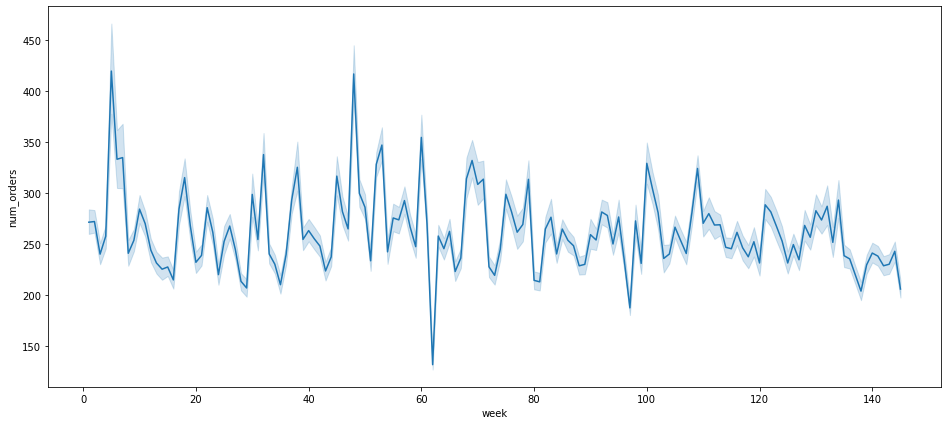

In [13]:
plt.figure(figsize = (16, 7))
sns.lineplot(train['week'], train['num_orders'])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76]),
 <a list of 77 Text major ticklabel objects>)

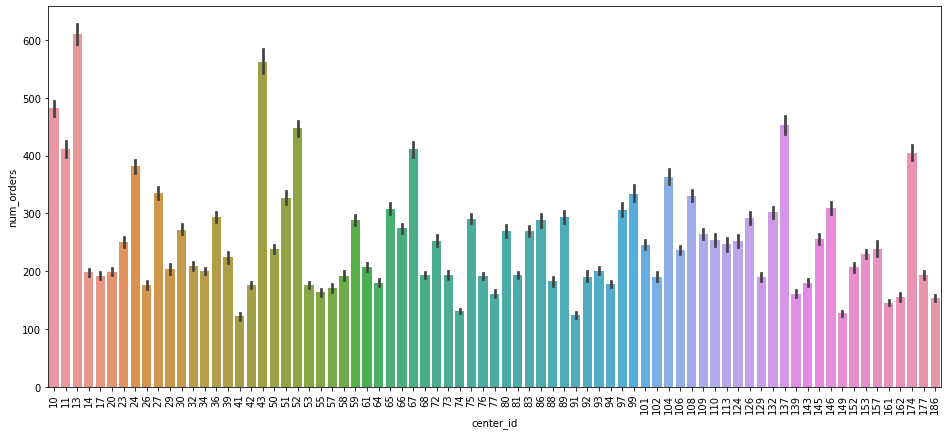

In [14]:
plt.figure(figsize = (16, 7))
sns.barplot(train['center_id'], train['num_orders'])
plt.xticks(rotation = 90)

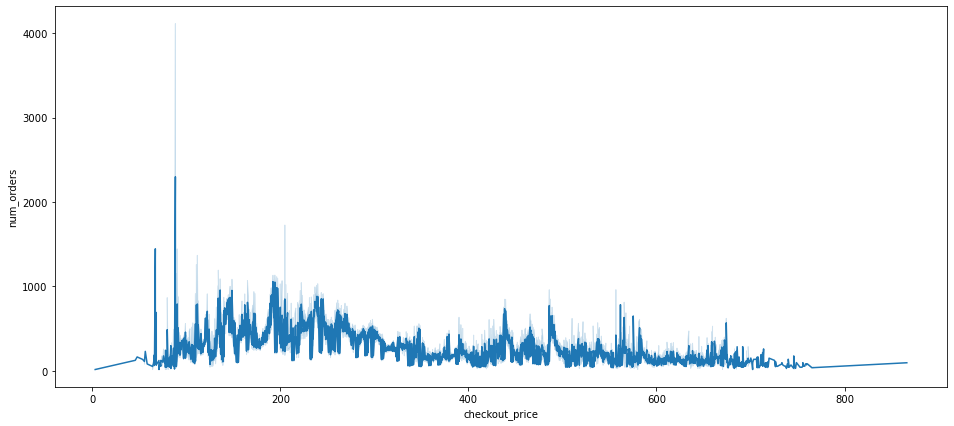

In [15]:
plt.figure(figsize = (16, 7))
sns.lineplot(train['checkout_price'], train['num_orders'])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text major ticklabel objects>)

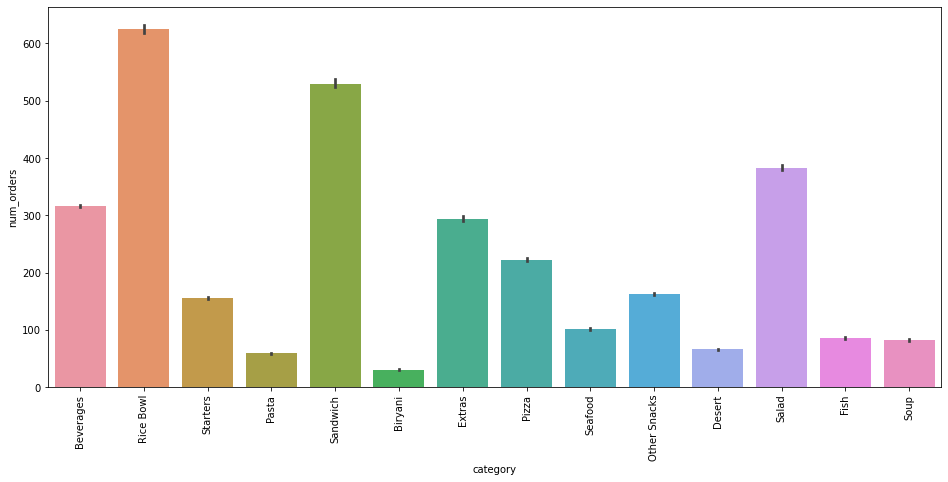

In [16]:
plt.figure(figsize = (16, 7))
sns.barplot(train['category'], train['num_orders'])
plt.xticks(rotation = '90')

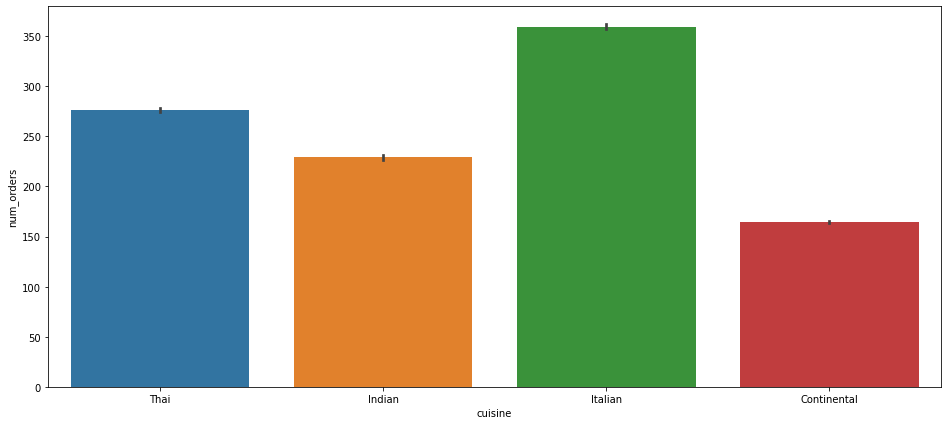

In [17]:
plt.figure(figsize = (16, 7))
sns.barplot(train['cuisine'], train['num_orders'])
#plt.xticks(rotation = '90')

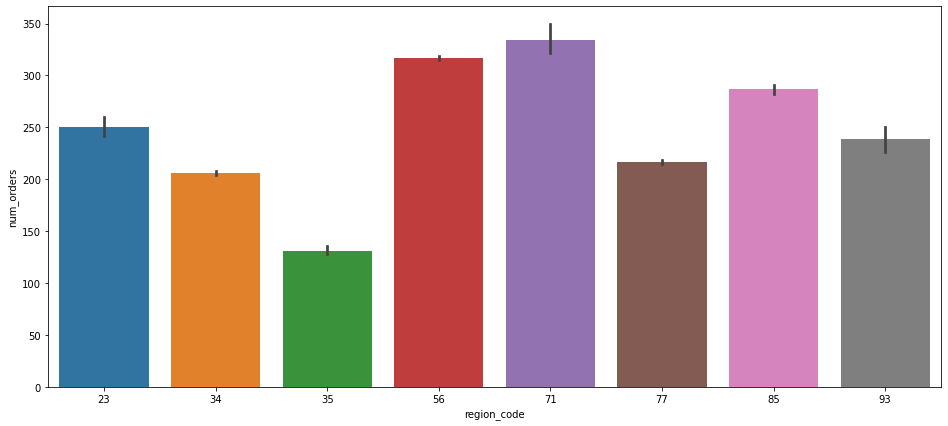

In [18]:
plt.figure(figsize = (16, 7))
sns.barplot(train['region_code'], train['num_orders'])
#plt.xticks(rotation = '90')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 30 Text major ticklabel objects>)

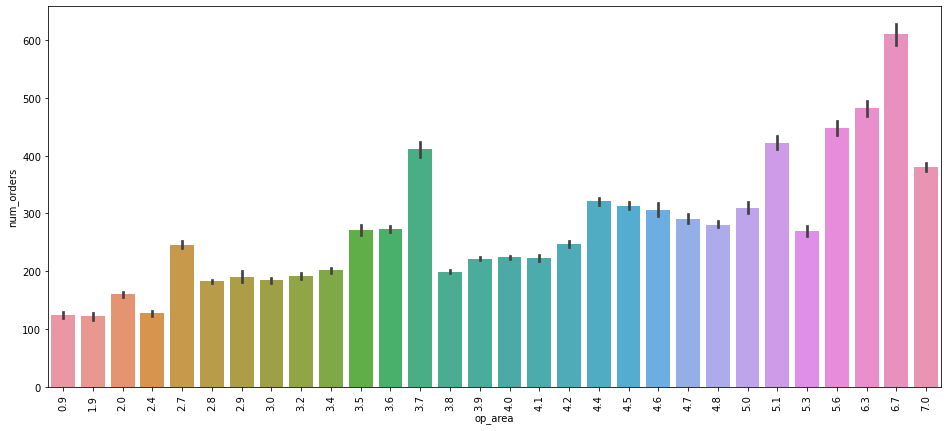

In [19]:
plt.figure(figsize = (16, 7))
sns.barplot(train['op_area'], train['num_orders'])
plt.xticks(rotation = '90')

(array([400., 450., 500., 550., 600., 650., 700., 750.]),
 <a list of 8 Text major ticklabel objects>)

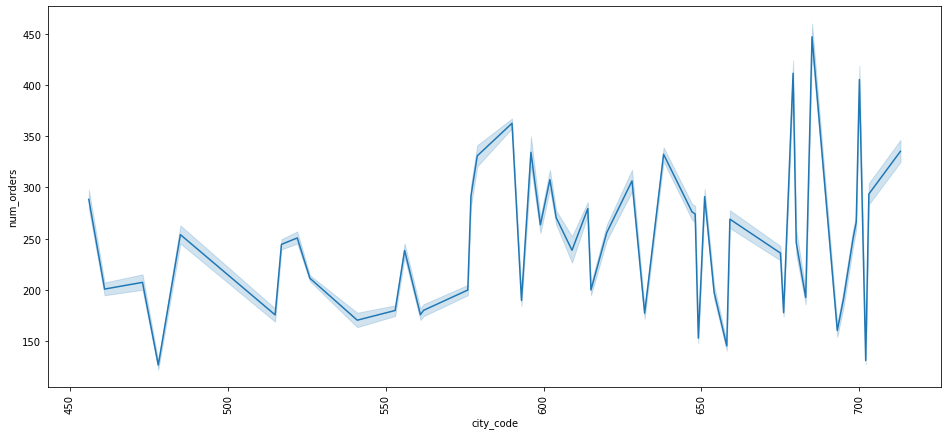

In [20]:
plt.figure(figsize = (16, 7))
sns.lineplot(train['city_code'], train['num_orders'])
plt.xticks(rotation = '90')

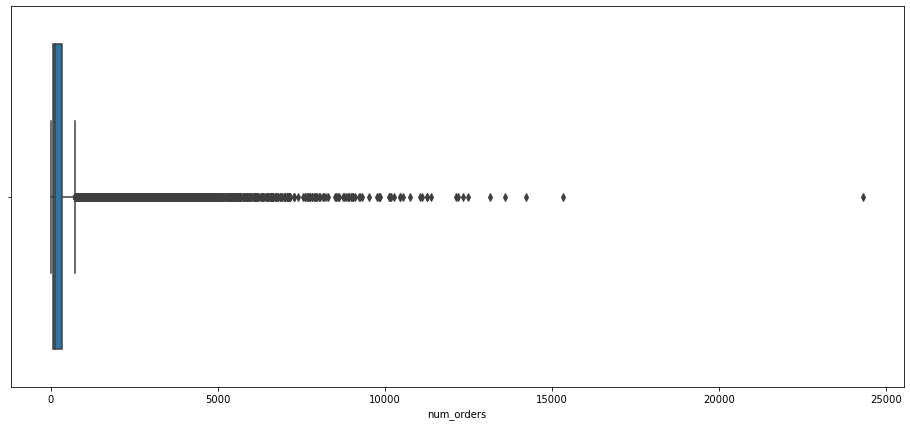

In [21]:
plt.figure(figsize = (16, 7))
sns.boxplot(x = 'num_orders', data = train)

Removing outliers from num_orders field

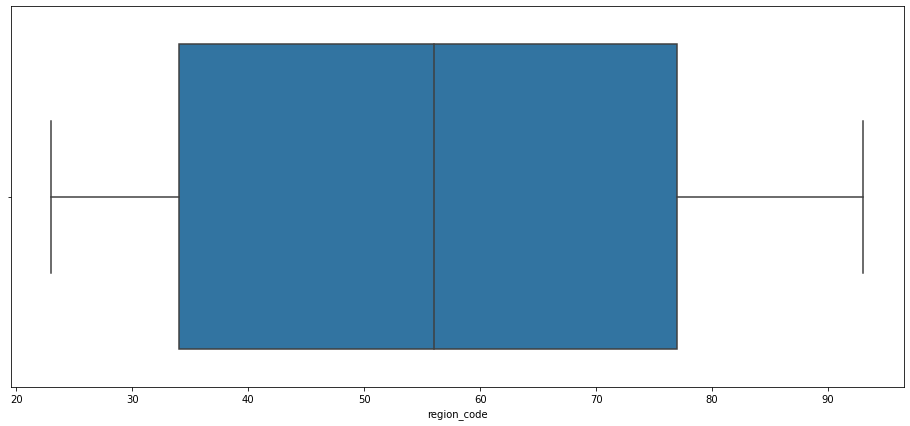

In [22]:
plt.figure(figsize = (16, 7))
sns.boxplot(x = 'region_code', data = train)

<Figure size 1152x504 with 0 Axes>

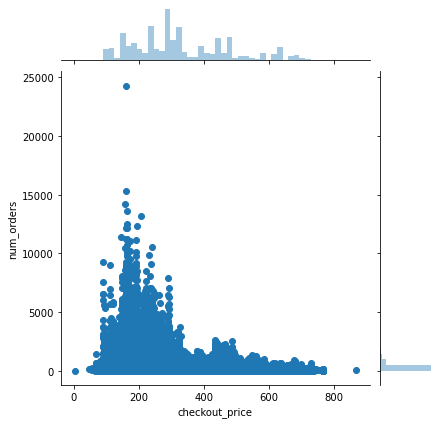

In [23]:
plt.figure(figsize = (16, 7))
sns.jointplot(x = 'checkout_price', y = 'num_orders', data = train)

We have removed outlier from check_out price and base price

<Figure size 1152x504 with 0 Axes>

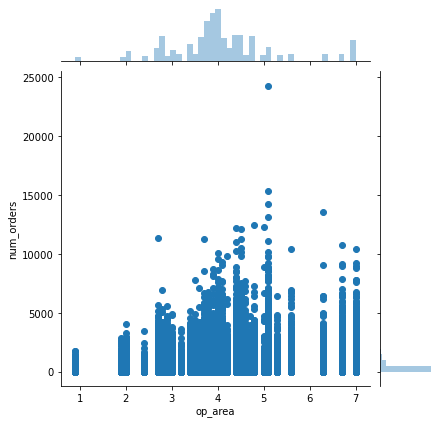

In [24]:
plt.figure(figsize = (16, 7))
sns.jointplot(x = 'op_area', y = 'num_orders', data = train)

<Figure size 1152x504 with 0 Axes>

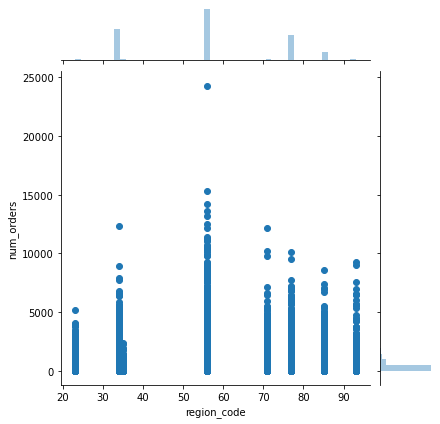

In [25]:
plt.figure(figsize = (16, 7))
sns.jointplot(x = 'region_code', y = 'num_orders', data = train)

<Figure size 1152x504 with 0 Axes>

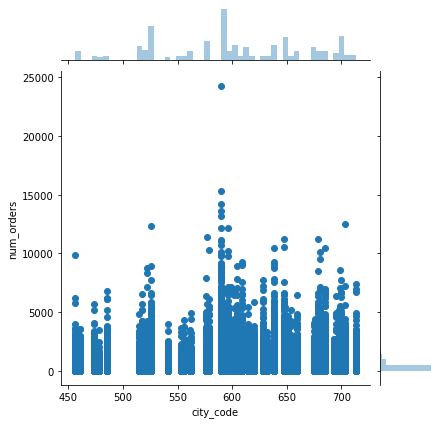

In [26]:
plt.figure(figsize = (16, 7))
sns.jointplot(x = 'city_code', y = 'num_orders', data = train)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text major ticklabel objects>)

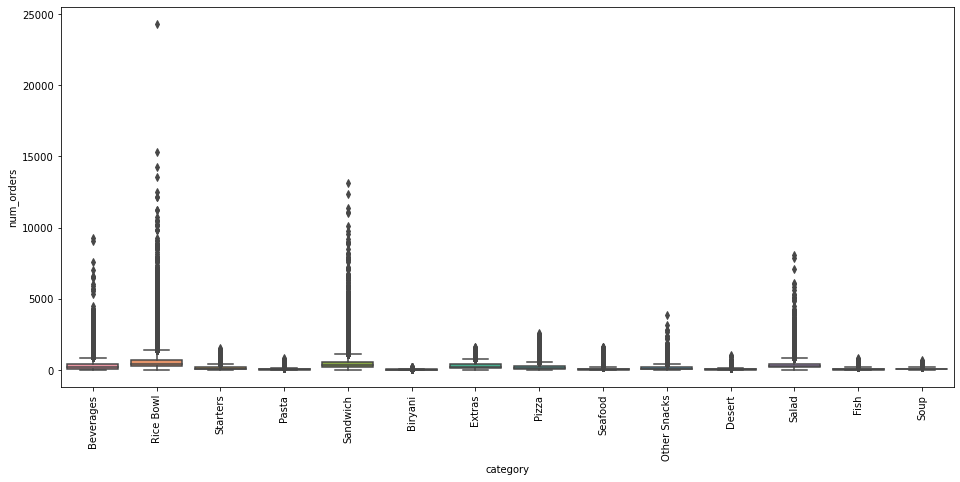

In [27]:
plt.figure(figsize = (16, 7))
sns.boxplot(x = 'category', y = 'num_orders', data = train)
plt.xticks(rotation = 90)

(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

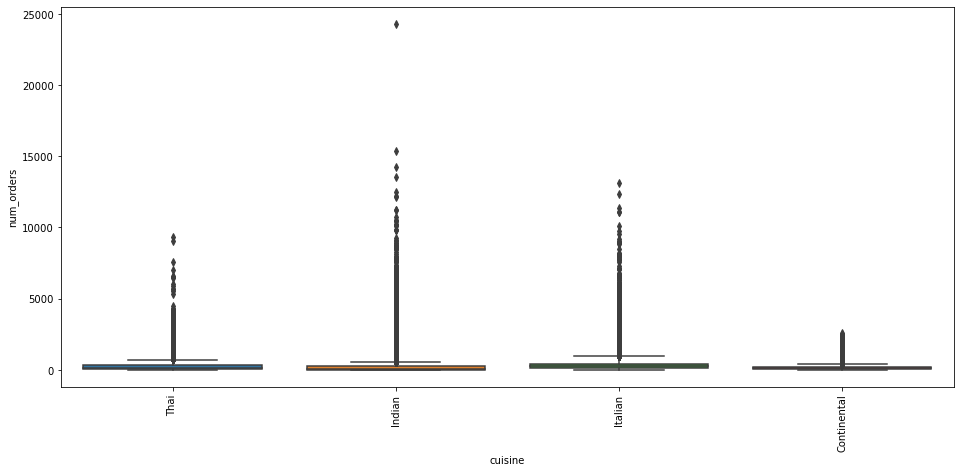

In [28]:
plt.figure(figsize = (16, 7))
sns.boxplot(x = 'cuisine',y = 'num_orders',data = train)
plt.xticks(rotation = 90)

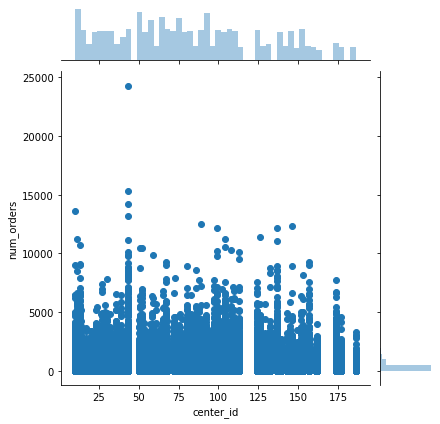

In [29]:
sns.jointplot(x = 'center_id', y = 'num_orders', data = train)

In [30]:
print("Total number of centers : ", train['center_id'].nunique())

Total number of centers :  77


In [31]:
print("Total Number of cities: ", train['city_code'].nunique())

Total Number of cities:  51


We have 77 stores in 51 cities, so some city have more than 1 center.

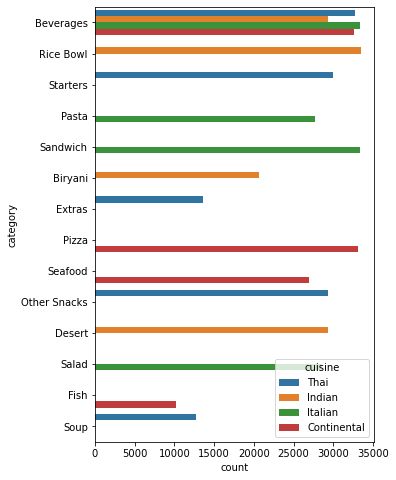

In [32]:
fig, ax = plt.subplots(figsize = (5, 8))
sns.countplot(y = train['category'], hue = train['cuisine'], ax = ax)
plt.show()

In [33]:
center_meal_train = (train['center_id'].astype(str) + "_" + train['meal_id'].astype(str)).unique()
print("There are", len(center_meal_train), "center-meal pairs in train data")

There are 3597 center-meal pairs in train data


In [34]:
center_meal_test = (test['center_id'].astype(str) + "_" + test['meal_id'].astype(str)).unique()
print("There are", len(center_meal_test), "center-meal pairs in train data")

There are 3548 center-meal pairs in train data


In [35]:
# check if test set has any new center-mean pair or not
print("There are",len(set(center_meal_test) - set(center_meal_train)), "New center-meal pairs in test dataset which are not present in train dataset")
print(set(center_meal_test) - set(center_meal_train))

There are 3 New center-meal pairs in test dataset which are not present in train dataset
{'73_1571', '92_2104', '73_2956'}


In [36]:
test[(test['center_id'] == 73) & (test['meal_id'].isin([2956, 1571]))].shape[0]

11

In [37]:
test[(test['center_id'] == 92) & (test['meal_id'].isin([2104]))].shape[0]

2

There should be 77*51 = 3927 center-meal pair, but we have 3597 pairs in train data, that means some centers did not sell some of the meals.

There should be 3597*145 = 521565 records in past 145 week data, but we have 456548 records. which means some centers did not sell some meal for some week or they stared selling some new type of meal after some weeks. Same with test data.

Test set has only 3548 center-meal pair, that means some of the centers did not sell some type of meals in this 10 week.

Here in the test set (future 10 week), center 73 started selling meal 2956 & 1571, center 92 started selling meal 2104, which they have never sold in last 145 weeks. There are only 13 records with unknown center-meal pair in test set.

#### Remove outlier

In [38]:
outlier_index = train[(train['num_orders'] > 15000)].index

In [39]:
train.drop(outlier_index, inplace = True)

#### Feature Engineering

In [40]:
train['train_or_test'] = 'train'
test['train_or_test'] = 'test'

In [41]:
train['num_orders'] = np.log1p(train['num_orders'])

In [42]:
total_data = train.append(test).reset_index(drop = True)[train.columns]

In [43]:
total_data = total_data.sort_values(['center_id', 'meal_id', 'week']).reset_index(drop = True)

In [44]:
total_data['checkout_price'] = np.log1p(total_data['checkout_price'])
total_data['base_price'] = np.log1p(total_data['base_price'])

In [45]:
total_data['discount_on_base'] = (total_data['base_price'] - total_data['checkout_price']) / total_data['base_price']

In [46]:
total_data["discount_ratio"] = total_data["base_price"] / total_data["checkout_price"]

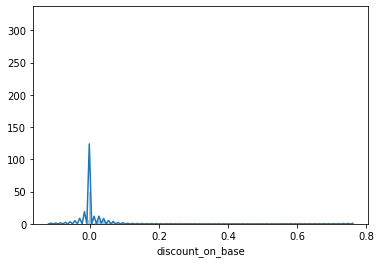

In [47]:
sns.distplot(total_data['discount_on_base'], bins = 500)
plt.show()

In [48]:
total_data['price_last_curr_diff'] = (total_data['checkout_price'].shift(1) - total_data['checkout_price']).fillna(1)/ total_data['checkout_price'].shift(1).fillna(1)

In [49]:
for _, r in total_data.groupby(['center_id', 'meal_id'])['week'].first().reset_index().iterrows():
    total_data.loc[(total_data['center_id'] == r['center_id']) & (total_data['meal_id'] == r['meal_id']) & (total_data['week'] == r['week']), 'price_last_curr_diff'] = total_data[(total_data['center_id'] == r['center_id']) & (total_data['meal_id'] == r['meal_id']) & (total_data['week'] != r['week'])]['price_last_curr_diff'].mean()
total_data['price_last_curr_diff'] = total_data['price_last_curr_diff'].fillna(0)

#### Some functions to create aggregated, rolling mean/median, and exponentially weighted features.

Code from : https://www.kaggle.com/abhilashawasthi/feature-engineering-lgb-model

In [50]:
# Features constructed from previous sales values

#Creating sales lag features
def create_sales_lag_feats(df, gpby_cols, target_col, lags):
    gpby = df.groupby(gpby_cols)
    for i in lags:
        df['_'.join([target_col, 'lag', str(i)])] = \
                gpby[target_col].shift(i).values + np.random.normal(scale = 1.6, size = (len(df),))
    return df

# Creating sales exponentially weighted mean features
def create_sales_ewm_feats(df, gpby_cols, target_col, alpha = [0.9], shift = [1]):
    gpby = df.groupby(gpby_cols)
    for a in alpha:
        for s in shift:
            df['_'.join([target_col, 'lag', str(s), 'ewm', str(a)])] = \
                gpby[target_col].shift(s).ewm(alpha = a).mean().values
    return df

In [51]:
# Creating num_orders lag, rolling mean, rolling median, ohe features of the above train set
total_data = create_sales_lag_feats(total_data, gpby_cols = ['center_id','meal_id'], target_col = 'num_orders', 
                               lags = [10, 11, 12])

total_data = create_sales_ewm_feats(total_data, gpby_cols = ['center_id', 'meal_id'], 
                               target_col = 'num_orders',
                               alpha=[0.5], 
                               shift=[10,11,12,13,14,15])

In [52]:
total_data.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,...,price_last_curr_diff,num_orders_lag_10,num_orders_lag_11,num_orders_lag_12,num_orders_lag_10_ewm_0.5,num_orders_lag_11_ewm_0.5,num_orders_lag_12_ewm_0.5,num_orders_lag_13_ewm_0.5,num_orders_lag_14_ewm_0.5,num_orders_lag_15_ewm_0.5
0,1436842,1,10,1062,5.206147,5.206147,0,0,6.763885,590,...,0.000086,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1205013,2,10,1062,5.216890,5.211451,0,0,6.663133,590,...,-0.002064,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1447751,3,10,1062,5.222300,5.211451,0,0,6.747587,590,...,-0.001037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1014968,4,10,1062,5.211451,5.216890,0,0,7.092574,590,...,0.002077,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1003563,5,10,1062,5.217053,5.206147,0,0,6.865891,590,...,-0.001075,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
### Center count features ###
gdf = total_data.groupby(["center_id", "week"])["id"].agg(['size']).reset_index()
gdf.columns = ["center_id", "week", "center_week_count"]
total_data = pd.merge(total_data,gdf, on = ["center_id", "week"], how = "left")

gdf = total_data.groupby(["center_id", "category"])["id"].count().reset_index()
gdf.columns = ["center_id", "category", "center_cat_count"]
total_data = pd.merge(total_data,gdf, on = ["center_id", "category"], how = "left")

gdf = total_data.groupby(["center_id", "category", "week"])["id"].count().reset_index()
gdf.columns = ["center_id", "category", "week", "center_cat_week_count"]
total_data = pd.merge(total_data,gdf, on = ["center_id", "category", "week"], how = "left")

gdf = total_data.groupby(["center_id", "cuisine"])["id"].count().reset_index()
gdf.columns = ["center_id", "cuisine", "center_cui_count"]
total_data = pd.merge(total_data,gdf, on = ["center_id", "cuisine"], how = "left")

In [54]:
### Meal count features ###
gdf = total_data.groupby(["meal_id"])["id"].count().reset_index()
gdf.columns = ["meal_id", "meal_count"]
total_data = pd.merge(total_data,gdf, on = ["meal_id"], how = "left")

gdf = total_data.groupby(["region_code", "meal_id"])["id"].count().reset_index()
gdf.columns = ["region_code", "meal_id", "region_meal_count"]
total_data= pd.merge(total_data,gdf, on = ["region_code", "meal_id"], how = "left")

gdf = total_data.groupby(["meal_id", "week"])["id"].count().reset_index()
gdf.columns = ["meal_id", "week", "meal_week_count"]
total_data = pd.merge(total_data,gdf, on = ["meal_id", "week"], how = "left")

gdf =total_data.groupby(["center_type", "meal_id", "week"])["id"].count().reset_index()
gdf.columns = ["center_type", "meal_id", "week", "type_meal_week_count"]
total_data = pd.merge(total_data,gdf, on = ["center_type", "meal_id", "week"], how = "left")

gdf = total_data.groupby(["region_code", "meal_id", "week"])["id"].count().reset_index()
gdf.columns = ["region_code", "meal_id", "week", "region_meal_week_count"]
total_data = pd.merge(total_data,gdf, on = ["region_code", "meal_id", "week"], how = "left")

gdf =total_data.groupby(["city_code", "meal_id", "week"])["id"].count().reset_index()
gdf.columns = ["city_code", "meal_id", "week", "city_meal_week_count"]
total_data = pd.merge(total_data,gdf, on = ["city_code", "meal_id", "week"], how = "left")

In [55]:
### Price rank ###

total_data["meal_price_rank"] = total_data.groupby("meal_id")["checkout_price"].rank()
total_data["meal_city_price_rank"] = total_data.groupby(["meal_id", "city_code"])["checkout_price"].rank()
total_data["meal_region_price_rank"] = total_data.groupby(["meal_id", "region_code"])["checkout_price"].rank()
total_data["meal_week_price_rank"] = total_data.groupby(["meal_id", "week"])["checkout_price"].rank()

total_data["center_price_rank"] = total_data.groupby("center_id")["checkout_price"].rank()
total_data["center_week_price_rank"] = total_data.groupby(["center_id", "week"])["checkout_price"].rank()
total_data["center_cat_price_rank"] = total_data.groupby(["center_id", "category"])["checkout_price"].rank()

In [56]:
### Week features ###

gdf = total_data.groupby(["meal_id"])["checkout_price"].agg(["min", "max", "mean", "std"]).reset_index()
gdf.columns = ["meal_id", "meal_price_min", "meal_price_max", "meal_price_mean", "meal_price_std"]
total_data = pd.merge(total_data,gdf, on = ["meal_id"], how = "left")

gdf = total_data.groupby(["meal_id"])["base_price"].agg(["min", "max", "mean", "std"]).reset_index()
gdf.columns = ["meal_id", "disc_price_min", "disc_price_max", "disc_price_mean", "disc_price_std"]
total_data = pd.merge(total_data,gdf, on = ["meal_id"], how = "left")

gdf = total_data.groupby(["city_code","meal_id", "week"])["checkout_price"].agg(["min", "max", "mean", "std"]).reset_index()
gdf.columns = ["city_code", "meal_id", "week", "meal_price2_min", "meal_price2_max", "meal_price2_mean", "meal_price2_std"]
total_data= pd.merge(total_data,gdf, on = ["city_code", "meal_id", "week"], how = "left")

gdf = total_data.groupby(["city_code", "category"])["checkout_price"].agg(["mean", "std"]).reset_index()
gdf.columns = ["city_code", "category", "meal_price3_mean", "meal_price3_std"]
total_datal = pd.merge(total_data,gdf, on = ["city_code", "category"], how = "left")

In [57]:
total_data['center_id'] = total_data['center_id'].astype(np.object)
total_data['meal_id'] = total_data['meal_id'].astype(np.object)
total_data['region_code'] = total_data['region_code'].astype(np.object)
total_datal['city_code'] = total_data['city_code'].astype(np.object)

In [58]:
train_data = total_data.loc[total_data['train_or_test'] == 'train', :]
test_data = total_data.loc[total_data['train_or_test'] == 'test', :]

In [59]:
center_meal_mean = train_data.groupby(['center_id', 'meal_id'])['num_orders'].mean()
center_meal_mean = center_meal_mean.reset_index()
center_meal_mean = center_meal_mean.rename(columns = {'num_orders':'avg_orders'})
train_data = pd.merge(train_data,center_meal_mean, how = 'left', left_on = ['center_id', 'meal_id'], right_on = ['center_id', 'meal_id'])
test_data = pd.merge(test_data,center_meal_mean, how = 'left', left_on = ['center_id', 'meal_id'], right_on = ['center_id', 'meal_id'])
center_mean = train_data.groupby('center_id')['num_orders'].mean()
center_mean = center_mean.reset_index()
center_mean = center_mean.rename(columns = {'num_orders':'avg_center'})
train_data = pd.merge(train_data,center_mean, how = 'left', left_on = ['center_id'], right_on = ['center_id'])
test_data = pd.merge(test_data,center_mean, how = 'left', left_on = ['center_id'], right_on = ['center_id'])
meal_mean = train_data.groupby('meal_id')['num_orders'].mean()
meal_mean = meal_mean.reset_index()
meal_mean = meal_mean.rename(columns = {'num_orders':'avg_meal'})
train_data = pd.merge(train_data, meal_mean,how = 'left',left_on = ['meal_id'], right_on = ['meal_id'])
test_data = pd.merge(test_data, meal_mean,how = 'left',left_on = ['meal_id'], right_on = ['meal_id'])

In [60]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 456546 entries, 0 to 456545
Data columns (total 60 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   id                         456546 non-null  int64  
 1   week                       456546 non-null  int64  
 2   center_id                  456546 non-null  object 
 3   meal_id                    456546 non-null  object 
 4   checkout_price             456546 non-null  float64
 5   base_price                 456546 non-null  float64
 6   emailer_for_promotion      456546 non-null  int64  
 7   homepage_featured          456546 non-null  int64  
 8   num_orders                 456546 non-null  float64
 9   city_code                  456546 non-null  int64  
 10  region_code                456546 non-null  object 
 11  center_type                456546 non-null  object 
 12  op_area                    456546 non-null  float64
 13  category                   45

In [61]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32573 entries, 0 to 32572
Data columns (total 60 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         32573 non-null  int64  
 1   week                       32573 non-null  int64  
 2   center_id                  32573 non-null  object 
 3   meal_id                    32573 non-null  object 
 4   checkout_price             32573 non-null  float64
 5   base_price                 32573 non-null  float64
 6   emailer_for_promotion      32573 non-null  int64  
 7   homepage_featured          32573 non-null  int64  
 8   num_orders                 0 non-null      float64
 9   city_code                  32573 non-null  int64  
 10  region_code                32573 non-null  object 
 11  center_type                32573 non-null  object 
 12  op_area                    32573 non-null  float64
 13  category                   32573 non-null  obj

### Catboost Model

In [62]:
avoid_column = ['id', 'num_orders', 'train_or_test']

In [63]:
features = [col for col in test_data.columns if col not in avoid_column]

In [64]:
features

['week',
 'center_id',
 'meal_id',
 'checkout_price',
 'base_price',
 'emailer_for_promotion',
 'homepage_featured',
 'city_code',
 'region_code',
 'center_type',
 'op_area',
 'category',
 'cuisine',
 'discount_on_base',
 'discount_ratio',
 'price_last_curr_diff',
 'num_orders_lag_10',
 'num_orders_lag_11',
 'num_orders_lag_12',
 'num_orders_lag_10_ewm_0.5',
 'num_orders_lag_11_ewm_0.5',
 'num_orders_lag_12_ewm_0.5',
 'num_orders_lag_13_ewm_0.5',
 'num_orders_lag_14_ewm_0.5',
 'num_orders_lag_15_ewm_0.5',
 'center_week_count',
 'center_cat_count',
 'center_cat_week_count',
 'center_cui_count',
 'meal_count',
 'region_meal_count',
 'meal_week_count',
 'type_meal_week_count',
 'region_meal_week_count',
 'city_meal_week_count',
 'meal_price_rank',
 'meal_city_price_rank',
 'meal_region_price_rank',
 'meal_week_price_rank',
 'center_price_rank',
 'center_week_price_rank',
 'center_cat_price_rank',
 'meal_price_min',
 'meal_price_max',
 'meal_price_mean',
 'meal_price_std',
 'disc_price_min

In [65]:
categorical_features_indices = np.where(train_data[features].dtypes == 'object')[0]
categorical_features_indices

array([ 1,  2,  8,  9, 11, 12])

In [66]:
model = CatBoostRegressor(
    iterations = 2000, 
    learning_rate = 0.02, 
    max_depth = 8, 
    l2_leaf_reg = 10, 
    loss_function = 'RMSE',
    random_seed = 22,
    od_type = 'Iter',
    od_wait = 25,
    verbose = 100,
    use_best_model = True
    )

In [67]:
errcb = []
y_pred_test = []

fold = KFold(n_splits = 5,shuffle = True, random_state = 22)

for train_index, test_index in fold.split(train_data[features],train_data['num_orders']):
    X_train, X_valid = train_data[features].iloc[train_index], train_data[features].iloc[test_index]
    y_train, y_valid = train_data['num_orders'][train_index],train_data['num_orders'][test_index]
    model.fit(X_train,y_train,
              cat_features = categorical_features_indices,
              eval_set = (X_valid, y_valid),
              early_stopping_rounds = 300,
              verbose = 100)
    preds = model.predict(X_valid)
    print("err: ", np.sqrt(mean_squared_error(y_valid,preds)))
    errcb.append(np.sqrt(mean_squared_error(y_valid,preds)))
    p = model.predict(test_data[features])
    y_pred_test.append(p)

0:	learn: 1.1847118	test: 1.1859358	best: 1.1859358 (0)	total: 647ms	remaining: 21m 33s
100:	learn: 0.5388927	test: 0.5405548	best: 0.5405548 (100)	total: 52.7s	remaining: 16m 31s
200:	learn: 0.4974890	test: 0.4992831	best: 0.4992831 (200)	total: 1m 46s	remaining: 15m 56s
300:	learn: 0.4871411	test: 0.4892787	best: 0.4892787 (300)	total: 2m 36s	remaining: 14m 44s
400:	learn: 0.4804938	test: 0.4829872	best: 0.4829872 (400)	total: 3m 26s	remaining: 13m 42s
500:	learn: 0.4757703	test: 0.4786597	best: 0.4786597 (500)	total: 4m 16s	remaining: 12m 46s
600:	learn: 0.4720191	test: 0.4752336	best: 0.4752336 (600)	total: 5m 5s	remaining: 11m 52s
700:	learn: 0.4687653	test: 0.4723110	best: 0.4723110 (700)	total: 5m 57s	remaining: 11m 1s
800:	learn: 0.4656962	test: 0.4695797	best: 0.4695797 (800)	total: 6m 47s	remaining: 10m 9s
900:	learn: 0.4631252	test: 0.4673708	best: 0.4673708 (900)	total: 7m 37s	remaining: 9m 17s
1000:	learn: 0.4611573	test: 0.4657218	best: 0.4657218 (1000)	total: 8m 26s	rema

In [68]:
model.fit(X = train_data[features], y = train_data['num_orders'], cat_features = categorical_features_indices,
          eval_set = (X_valid, y_valid), verbose = 100)

0:	learn: 1.1847998	test: 1.1856397	best: 1.1856397 (0)	total: 788ms	remaining: 26m 14s
100:	learn: 0.5389422	test: 0.5383869	best: 0.5383869 (100)	total: 1m 4s	remaining: 20m 21s
200:	learn: 0.4974361	test: 0.4968773	best: 0.4968773 (200)	total: 2m 7s	remaining: 19m 3s
300:	learn: 0.4871069	test: 0.4864448	best: 0.4864448 (300)	total: 3m 8s	remaining: 17m 42s
400:	learn: 0.4805398	test: 0.4797376	best: 0.4797376 (400)	total: 4m 9s	remaining: 16m 33s
500:	learn: 0.4757329	test: 0.4748562	best: 0.4748562 (500)	total: 5m 9s	remaining: 15m 26s
600:	learn: 0.4720355	test: 0.4710762	best: 0.4710762 (600)	total: 6m 11s	remaining: 14m 24s
700:	learn: 0.4688485	test: 0.4678497	best: 0.4678497 (700)	total: 7m 13s	remaining: 13m 22s
800:	learn: 0.4661252	test: 0.4650717	best: 0.4650717 (800)	total: 8m 15s	remaining: 12m 21s
900:	learn: 0.4637136	test: 0.4626245	best: 0.4626245 (900)	total: 9m 19s	remaining: 11m 22s
1000:	learn: 0.4615561	test: 0.4604251	best: 0.4604251 (1000)	total: 10m 22s	rema

In [69]:
pred = model.predict(test_data[features])

In [70]:
pred = (np.exp(pred) - 1)

In [71]:
submission = pd.DataFrame({'id':test['id'],'num_orders':pred})
submission = submission[['id','num_orders']]
submission.head()

,id,num_orders
0,1028232,1007.538010
1,1262649,1043.200522
2,1453211,1005.587753
3,1262599,773.685079
4,1495848,1008.109439


In [72]:
submission.to_csv('catboost_1.csv', index = False)

In [73]:
feature_score = pd.DataFrame(list(zip(train_data[features].dtypes.index, model.get_feature_importance(Pool(train_data[features], label=train_data['num_orders'], cat_features=categorical_features_indices)))),
                columns=['Feature','Score'])

feature_score = feature_score.sort_values(by = 'Score', ascending = False, inplace = False, 
                                          kind = 'quicksort', na_position = 'last')

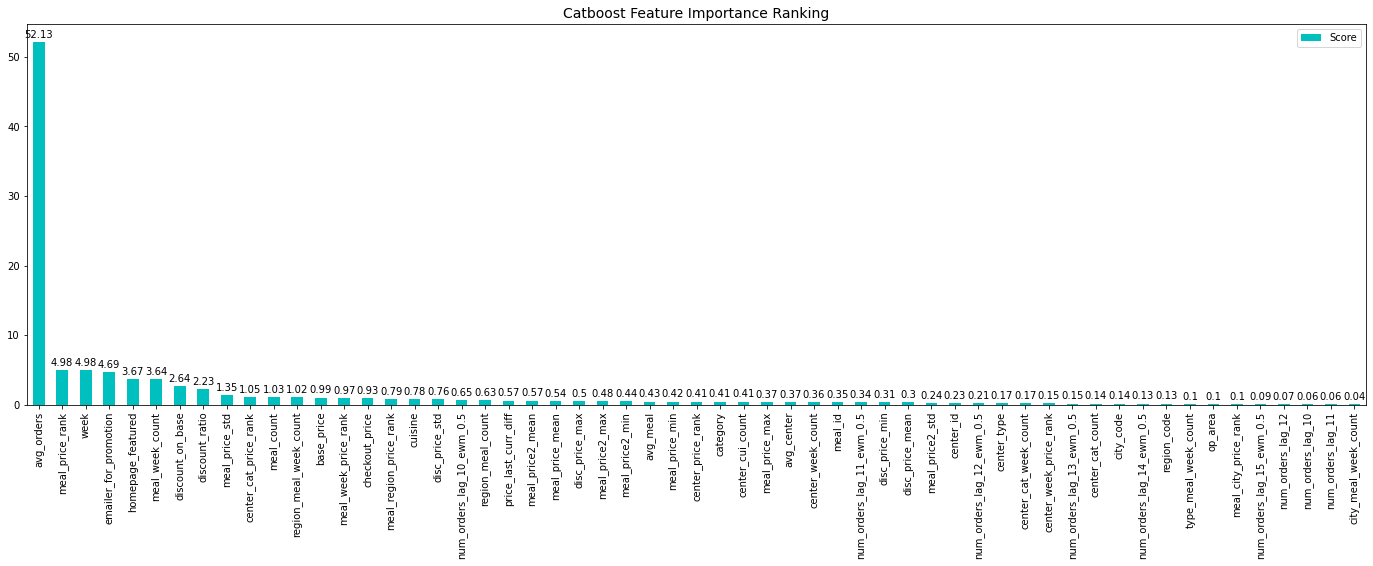

In [74]:
plt.rcParams["figure.figsize"] = (24,7)
ax = feature_score.plot('Feature', 'Score', kind = 'bar', color = 'c')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')

rects = ax.patches

labels = feature_score['Score'].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha = 'center', va = 'bottom')

plt.show()